In [ ]:
dataset_root = '/content/483/My Drive/483_final/'
from google.colab import drive
drive.mount('/content/483')

Mounted at /content/483


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


### Part 1: Graph Construction
Using two separate data sources, which are the protein to gene data and the gene disease associations (see report for more detail on these datasets), we construct graphs to train graph neural networks. Each of the proteins, genese, and diseases becomes a nodes in the graph, and the relevant edges are drawn with the edge features coming from the aforementioned datasets. Each feature is normalized.

In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
import os
import numpy as np

protein_to_gene_file = os.path.join(dataset_root, 'protein_to_gene_filtered.csv')
df_protein_to_gene = pd.read_csv(protein_to_gene_file)

psychiatric_disorders_file = os.path.join(dataset_root, "psychiatric_disorders_full_GDA.csv")
df_psychiatric_disorders = pd.read_csv(psychiatric_disorders_file)

protein_edge_feature_columns = [
    "neighborhood", "fusion", "cooccurence", "coexpression",
    "experimental", "database", "textmining", "combined_score"
]
for col in protein_edge_feature_columns:
    scaler = MinMaxScaler()
    df_protein_to_gene[col] = scaler.fit_transform(df_protein_to_gene[[col]])

disorder_edge_feature_columns = [
    "score", "yearInitial", "yearFinal", "numPMIDs", "evidence_index"
]
for col in disorder_edge_feature_columns:
    scaler = MinMaxScaler()
    df_psychiatric_disorders[col] = scaler.fit_transform(df_psychiatric_disorders[[col]])

def is_valid_protein_class(text):
    if pd.isna(text) or ';' in str(text) or any(char.isdigit() for char in str(text)):
        return False
    return True

df_psychiatric_disorders['valid_protein_class'] = df_psychiatric_disorders['protein_class_name'].apply(is_valid_protein_class)
valid_classes = df_psychiatric_disorders[df_psychiatric_disorders['valid_protein_class']]['protein_class_name']
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(valid_classes.values.reshape(-1, 1))

node_dict = {}
node_type_dict = {}
node_index = 0

def get_node_index(node, node_type):
    global node_index
    if node not in node_dict:
        node_dict[node] = node_index
        node_type_dict[node_index] = node_type
        node_index += 1
    return node_dict[node]

edge_index = []
edge_features = []

for _, row in df_protein_to_gene.iterrows():
    protein1 = row["protein1"]
    protein2 = row["protein2"]
    gene1 = row["gene1"]
    gene2 = row["gene2"]

    p1_idx = get_node_index(protein1, 0)  # Protein node
    p2_idx = get_node_index(protein2, 0)  # Protein node
    g1_idx = get_node_index(gene1, 1)     # Gene node
    g2_idx = get_node_index(gene2, 1)     # Gene node

    for source, target in [(p1_idx, p2_idx), (p1_idx, g1_idx), (p1_idx, g2_idx)]:
        edge_index.append([source, target])
        edge_index.append([target, source])

        edge_features.append(row[protein_edge_feature_columns].values)
        edge_features.append(row[protein_edge_feature_columns].values)

for _, row in df_psychiatric_disorders.iterrows():
    gene = row["gene_symbol"]
    disease = row["disease_name"]

    if pd.isna(disease) or pd.isna(gene):
        continue

    if gene in node_dict:
        gene_idx = get_node_index(gene, 1)  # Gene node
        disease_idx = get_node_index(disease, 2)  # Disease node

        edge_index.append([gene_idx, disease_idx])
        edge_index.append([disease_idx, gene_idx])

        numerical_features = row[disorder_edge_feature_columns].values

        if row['valid_protein_class']:
            protein_class_features = encoder.transform([[row['protein_class_name']]])[0]
        else:
            protein_class_features = np.zeros(len(encoder.get_feature_names_out()))

        combined_features = np.concatenate([numerical_features, protein_class_features])

        edge_features.append(combined_features)
        edge_features.append(combined_features)

In [ ]:
max_edge_feature_size = max(len(edge) for edge in edge_features)
padded_edge_features = [
    list(edge) + [0] * (max_edge_feature_size - len(edge)) for edge in edge_features
]

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(padded_edge_features, dtype=torch.float)

num_nodes = len(node_dict)
node_features = torch.zeros((num_nodes, 1), dtype=torch.float)
for idx, node_type in node_type_dict.items():
    node_features[idx] = node_type  # 0 for protein, 1 for gene, 2 for disease

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

### Part 2: Training a Multi-hop GAT to Predict New Edges (Vamsi)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.utils import negative_sampling

class MultiHopAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, num_hops, heads=1):
        super(MultiHopAttention, self).__init__()
        self.num_hops = num_hops

        self.input_projection = torch.nn.Linear(in_channels, hidden_channels1)

        self.gnn_layers = torch.nn.ModuleList([
            GATConv(hidden_channels1 if i == 0 else hidden_channels2, hidden_channels2, heads=heads, concat=False)
            for i in range(num_hops)
        ])
        self.attention_layers = torch.nn.ModuleList([
            torch.nn.Linear(hidden_channels2, 1) for _ in range(num_hops)
        ])

    def forward(self, x, edge_index):
        x = F.relu(self.input_projection(x))

        hop_embeddings = []
        for i in range(self.num_hops):
            x = F.relu(self.gnn_layers[i](x, edge_index))
            attention_weights = torch.sigmoid(self.attention_layers[i](x))
            hop_embeddings.append(attention_weights * x)

        out = torch.stack(hop_embeddings, dim=0).mean(dim=0)
        return out


class EdgePredictionModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, num_hops, heads=1):
        super(EdgePredictionModel, self).__init__()
        self.multi_hop_attention = MultiHopAttention(in_channels, hidden_channels1, hidden_channels2, num_hops, heads)
        self.edge_predictor = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_channels2, hidden_channels2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels2, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x, edge_index, edge_label_index):
        node_embeddings = self.multi_hop_attention(x, edge_index)

        source_embeddings = node_embeddings[edge_label_index[0]]
        target_embeddings = node_embeddings[edge_label_index[1]]
        edge_embeddings = torch.cat([source_embeddings, target_embeddings], dim=1)

        return self.edge_predictor(edge_embeddings).squeeze()

Epoch 1:
Train - Loss: 0.6932, Acc: 0.5000, F1: 0.6667, AUC: 0.5438
Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.6667, AUC: 0.6403
Epoch 2:
Train - Loss: 0.6930, Acc: 0.5000, F1: 0.6667, AUC: 0.6399
Val   - Loss: 0.6928, Acc: 0.5000, F1: 0.6667, AUC: 0.6391
Epoch 3:
Train - Loss: 0.6928, Acc: 0.5000, F1: 0.6667, AUC: 0.6391
Val   - Loss: 0.6925, Acc: 0.6386, F1: 0.7345, AUC: 0.6389
Epoch 4:
Train - Loss: 0.6925, Acc: 0.6386, F1: 0.7345, AUC: 0.6390
Val   - Loss: 0.6923, Acc: 0.5894, F1: 0.6193, AUC: 0.6385
Epoch 5:
Train - Loss: 0.6923, Acc: 0.5893, F1: 0.6193, AUC: 0.6384
Val   - Loss: 0.6919, Acc: 0.5942, F1: 0.6217, AUC: 0.6384
Epoch 6:
Train - Loss: 0.6919, Acc: 0.5942, F1: 0.6217, AUC: 0.6384
Val   - Loss: 0.6915, Acc: 0.5511, F1: 0.5349, AUC: 0.6383
Epoch 7:
Train - Loss: 0.6915, Acc: 0.5508, F1: 0.5347, AUC: 0.6378
Val   - Loss: 0.6910, Acc: 0.5891, F1: 0.6193, AUC: 0.6370
Epoch 8:
Train - Loss: 0.6910, Acc: 0.5890, F1: 0.6192, AUC: 0.6367
Val   - Loss: 0.6905, Acc: 0.5813, F1: 0.61

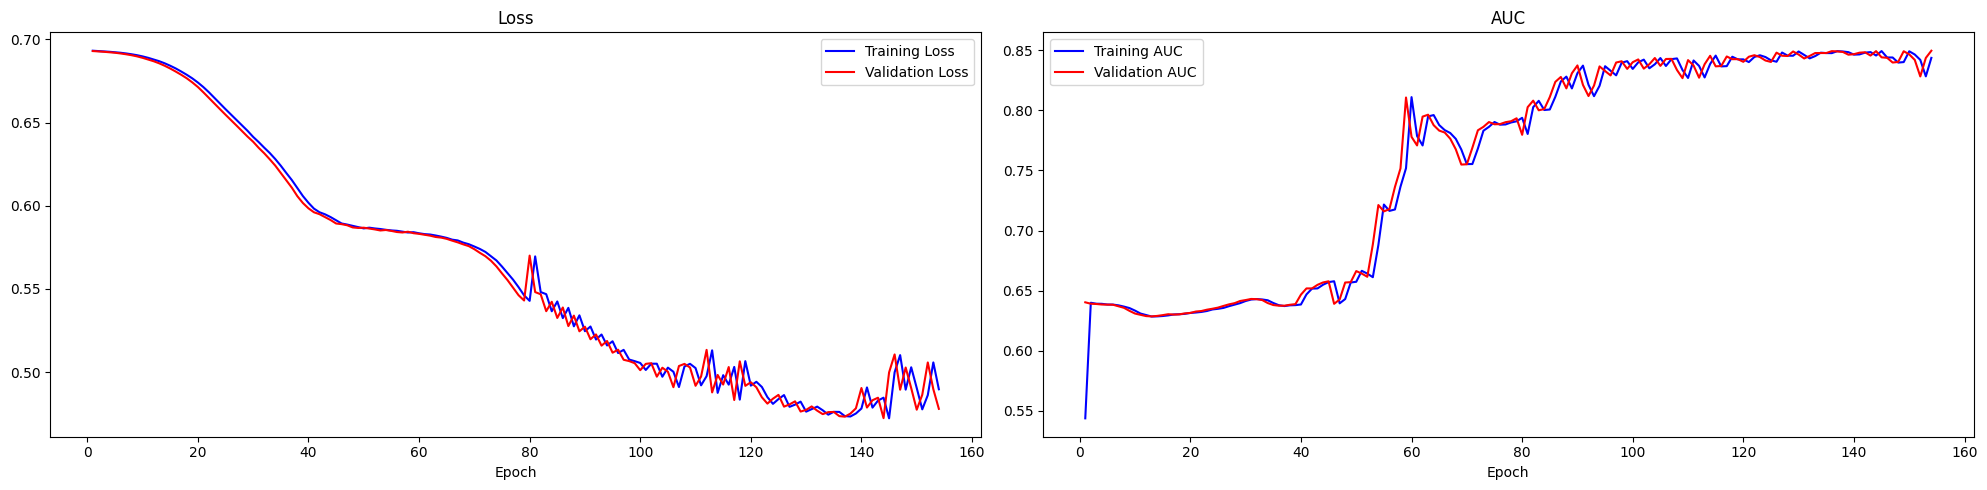

Epoch 1:
Train - Loss: 0.6932, Acc: 0.5000, F1: 0.6667, AUC: 0.5670
Val   - Loss: 0.6929, Acc: 0.5000, F1: 0.6667, AUC: 0.6362
Epoch 2:
Train - Loss: 0.6929, Acc: 0.5000, F1: 0.6667, AUC: 0.6364
Val   - Loss: 0.6927, Acc: 0.5000, F1: 0.6667, AUC: 0.6367
Epoch 3:
Train - Loss: 0.6927, Acc: 0.5000, F1: 0.6667, AUC: 0.6371
Val   - Loss: 0.6924, Acc: 0.6384, F1: 0.7344, AUC: 0.6372
Epoch 4:
Train - Loss: 0.6924, Acc: 0.6387, F1: 0.7346, AUC: 0.6375
Val   - Loss: 0.6920, Acc: 0.6390, F1: 0.7348, AUC: 0.6369
Epoch 5:
Train - Loss: 0.6920, Acc: 0.6391, F1: 0.7348, AUC: 0.6371
Val   - Loss: 0.6916, Acc: 0.5864, F1: 0.6181, AUC: 0.6359
Epoch 6:
Train - Loss: 0.6916, Acc: 0.5860, F1: 0.6179, AUC: 0.6355
Val   - Loss: 0.6911, Acc: 0.5188, F1: 0.4490, AUC: 0.6340
Epoch 7:
Train - Loss: 0.6911, Acc: 0.5190, F1: 0.4491, AUC: 0.6339
Val   - Loss: 0.6905, Acc: 0.5178, F1: 0.4337, AUC: 0.6320
Epoch 8:
Train - Loss: 0.6905, Acc: 0.5176, F1: 0.4337, AUC: 0.6317
Val   - Loss: 0.6898, Acc: 0.5316, F1: 0.51

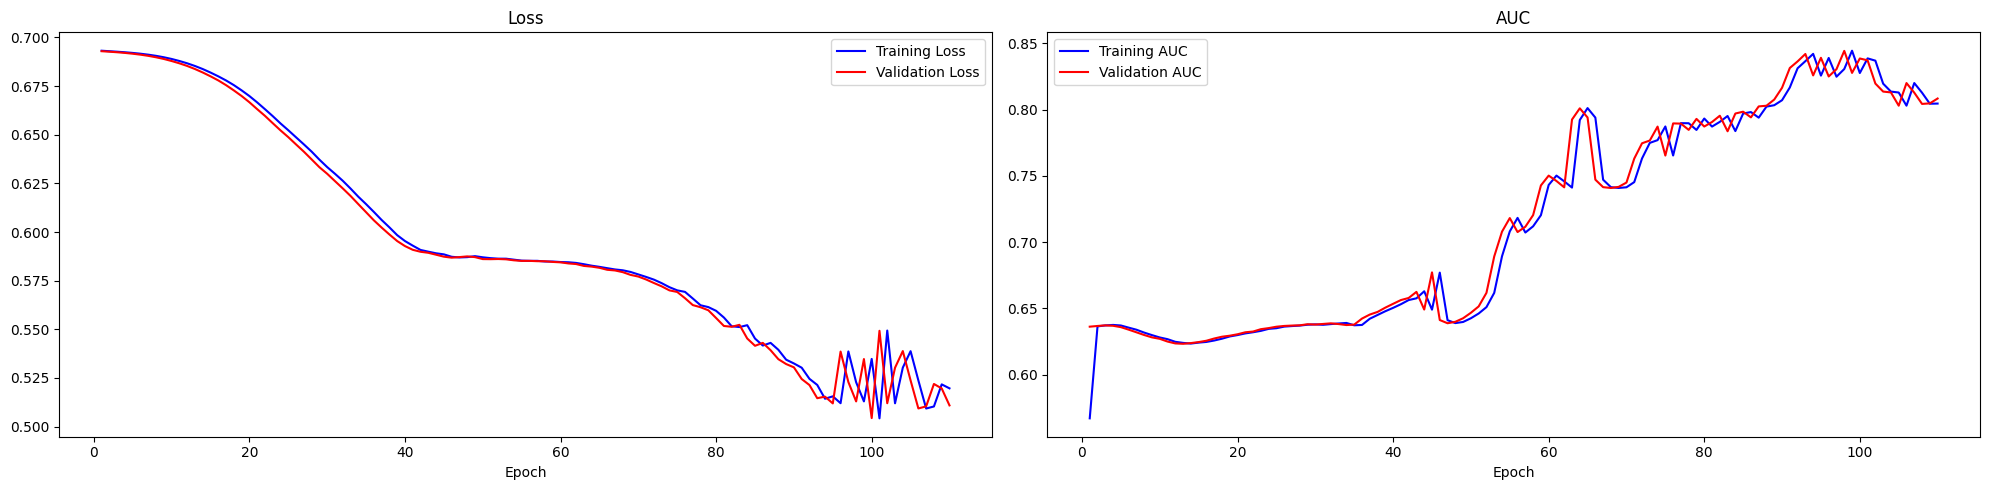

Epoch 1:
Train - Loss: 0.6942, Acc: 0.5000, F1: 0.0000, AUC: 0.3861
Val   - Loss: 0.6937, Acc: 0.5000, F1: 0.0000, AUC: 0.6384
Epoch 2:
Train - Loss: 0.6937, Acc: 0.5000, F1: 0.0000, AUC: 0.6379
Val   - Loss: 0.6933, Acc: 0.5000, F1: 0.0000, AUC: 0.6341
Epoch 3:
Train - Loss: 0.6933, Acc: 0.5000, F1: 0.0000, AUC: 0.6343
Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.6245
Epoch 4:
Train - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.6241
Val   - Loss: 0.6927, Acc: 0.5000, F1: 0.0000, AUC: 0.6126
Epoch 5:
Train - Loss: 0.6927, Acc: 0.5000, F1: 0.0000, AUC: 0.6122
Val   - Loss: 0.6924, Acc: 0.5000, F1: 0.0000, AUC: 0.6180
Epoch 6:
Train - Loss: 0.6924, Acc: 0.5000, F1: 0.0000, AUC: 0.6177
Val   - Loss: 0.6922, Acc: 0.5445, F1: 0.4230, AUC: 0.6234
Epoch 7:
Train - Loss: 0.6922, Acc: 0.5447, F1: 0.4231, AUC: 0.6233
Val   - Loss: 0.6919, Acc: 0.6383, F1: 0.7344, AUC: 0.6259
Epoch 8:
Train - Loss: 0.6919, Acc: 0.6383, F1: 0.7344, AUC: 0.6259
Val   - Loss: 0.6916, Acc: 0.6350, F1: 0.73

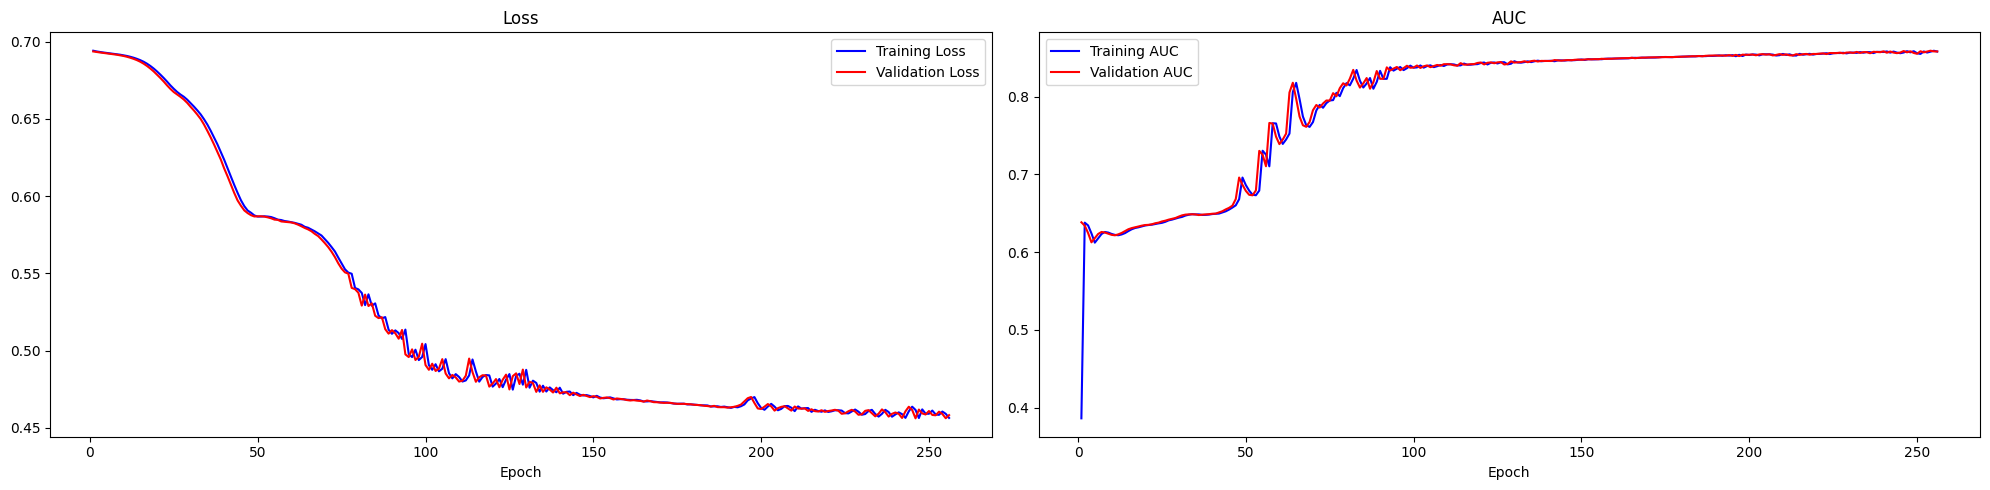

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

def train(model, data, optimizer, device='cpu'):
    model.train()
    data = data.to(device)
    model = model.to(device)

    optimizer.zero_grad()

    edge_label_index = data.edge_index
    edge_label = torch.ones(edge_label_index.size(1), device=device)

    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_index.size(1)
    )
    neg_edge_label = torch.zeros(neg_edge_index.size(1), device=device)

    combined_edge_index = torch.cat([edge_label_index, neg_edge_index], dim=1)
    combined_edge_label = torch.cat([edge_label, neg_edge_label], dim=0)

    edge_pred = model(data.x, data.edge_index, combined_edge_index)
    loss = F.binary_cross_entropy(edge_pred, combined_edge_label)

    loss.backward()
    optimizer.step()

    pred_binary = (edge_pred > 0.5).float()

    # Convert tensors to CPU numpy arrays for sklearn metrics
    pred_binary_np = pred_binary.cpu().numpy()
    edge_pred_np = edge_pred.detach().cpu().numpy()
    combined_edge_label_np = combined_edge_label.cpu().numpy()

    accuracy = (pred_binary_np == combined_edge_label_np).mean()
    f1 = f1_score(combined_edge_label_np, pred_binary_np)
    auc = roc_auc_score(combined_edge_label_np, edge_pred_np)

    return loss.item(), accuracy, f1, auc

def validate(model, data, device='cpu'):
    model.eval()
    data = data.to(device)
    model = model.to(device)

    with torch.no_grad():
        edge_label_index = data.edge_index
        edge_label = torch.ones(edge_label_index.size(1), device=device)

        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=data.edge_index.size(1)
        )
        neg_edge_label = torch.zeros(neg_edge_index.size(1), device=device)

        combined_edge_index = torch.cat([edge_label_index, neg_edge_index], dim=1)
        combined_edge_label = torch.cat([edge_label, neg_edge_label], dim=0)

        edge_pred = model(data.x, data.edge_index, combined_edge_index)
        loss = F.binary_cross_entropy(edge_pred, combined_edge_label)

        pred_binary = (edge_pred > 0.5).float()

        # Convert tensors to CPU numpy arrays for sklearn metrics
        pred_binary_np = pred_binary.cpu().numpy()
        edge_pred_np = edge_pred.cpu().numpy()
        combined_edge_label_np = combined_edge_label.cpu().numpy()

        accuracy = (pred_binary_np == combined_edge_label_np).mean()
        f1 = f1_score(combined_edge_label_np, pred_binary_np)
        auc = roc_auc_score(combined_edge_label_np, edge_pred_np)

    return loss.item(), accuracy, f1, auc

def plot_metrics(train_metrics, val_metrics, save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    epochs = range(1, len(train_metrics['loss']) + 1)

    ax1.plot(epochs, train_metrics['loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, val_metrics['loss'], 'r-', label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(epochs, train_metrics['auc'], 'b-', label='Training AUC')
    ax2.plot(epochs, val_metrics['auc'], 'r-', label='Validation AUC')
    ax2.set_title('AUC')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for run in range(3):

  model = EdgePredictionModel(
      in_channels=1,
      hidden_channels1=64,
      hidden_channels2=128,
      num_hops=3,
      heads=4
  )

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  patience = 10
  best_val_loss = float('inf')
  patience_counter = 0

  train_metrics = {
      'loss': [], 'accuracy': [], 'f1': [], 'auc': []
  }
  val_metrics = {
      'loss': [], 'accuracy': [], 'f1': [], 'auc': []
  }

  for epoch in range(300):
      train_loss, train_acc, train_f1, train_auc = train(model, data, optimizer, device=device)
      val_loss, val_acc, val_f1, val_auc = validate(model, data, device=device)

      train_metrics['loss'].append(train_loss)
      train_metrics['accuracy'].append(train_acc)
      train_metrics['f1'].append(train_f1)
      train_metrics['auc'].append(train_auc)

      val_metrics['loss'].append(val_loss)
      val_metrics['accuracy'].append(val_acc)
      val_metrics['f1'].append(val_f1)
      val_metrics['auc'].append(val_auc)

      print(f'Epoch {epoch + 1}:')
      print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
      print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_val_acc = val_acc
          best_val_f1 = val_f1
          best_val_auc = val_auc
          patience_counter = 0
      else:
          patience_counter += 1

      if patience_counter >= patience:
          print(f"Early stopping at epoch {epoch + 1}")
          break

  print(f"\nBest Metrics for Run {run}:")
  print(f"Accuracy: {best_val_acc:.4f}, F1: {best_val_f1:.4f}, AUC: {best_val_auc:.4f}")

### Part 3: Training a GAT on Subgraphs to Predict New Edges (Brian)

Applying the Louvain algorithm, we first calculate "community" subgraphs between the larger all-encompassing graph that has 2981 nodes. Then, we train a GAT on each of these subgraphs to predict new edges.

In [ ]:
import networkx as nx
from community import community_louvain
from torch_geometric.utils import from_networkx, to_networkx, negative_sampling
from sklearn.metrics import roc_auc_score

G_nx = to_networkx(data, to_undirected=True)
partition = community_louvain.best_partition(G_nx)  # Apply Louvain
print(f"Number of communities: {len(set(partition.values()))}")

Number of communities: 3


In [ ]:
from torch_geometric.data import Data, Batch
community_to_nodes = {}
for node, comm in partition.items():
    if comm not in community_to_nodes:
        community_to_nodes[comm] = []
    community_to_nodes[comm].append(node)

subgraphs = []
for nodes in community_to_nodes.values():
    subgraph = G_nx.subgraph(nodes)
    subgraph_data = from_networkx(subgraph)
    if data.x is not None:
        subgraph_data.x = data.x[list(nodes)]
    else:
        import pdb; pdb.set_trace()
    subgraphs.append(subgraph_data)

dataset = Batch.from_data_list(subgraphs)

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, 8, heads=4, dropout=0.6)
        self.conv2 = GATConv(8 * 4, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

class EdgePredictionModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gat = GAT(in_channels, hidden_channels)
        self.edge_predictor = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels),
            torch.nn.Sigmoid()
        )

    def forward(self, x, edge_index, edge_label_index):
        z = self.gat(x, edge_index)
        source_embeddings = z[edge_label_index[0]]
        target_embeddings = z[edge_label_index[1]]
        edge_embeddings = torch.cat([source_embeddings, target_embeddings], dim=1)
        return self.edge_predictor(edge_embeddings).squeeze()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def train(model, dataset, optimizer, device):
    model.train()
    optimizer.zero_grad()

    z = model.gat(dataset.x, dataset.edge_index)

    pos_edge_index = dataset.edge_index
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=dataset.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    ).to(device)

    edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    edge_labels = torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ]).to(device)

    preds = model(dataset.x, dataset.edge_index, edge_label_index)
    loss = F.binary_cross_entropy(preds, edge_labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_true = edge_labels
        y_pred = preds
        y_pred_binary = (y_pred > 0.5).float()

        # Convert to numpy for sklearn metrics
        y_true_np = y_true.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()
        y_pred_binary_np = y_pred_binary.cpu().numpy()

        accuracy = (y_pred_binary_np == y_true_np).mean()
        f1 = f1_score(y_true_np, y_pred_binary_np)
        auc = roc_auc_score(y_true_np, y_pred_np)

    return loss.item(), accuracy, f1, auc

def validate(model, dataset, device):
    model.eval()
    with torch.no_grad():
        z = model.gat(dataset.x, dataset.edge_index)

        pos_edge_index = dataset.edge_index
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=dataset.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        ).to(device)

        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        edge_labels = torch.cat([
            torch.ones(pos_edge_index.size(1)),
            torch.zeros(neg_edge_index.size(1))
        ]).to(device)

        preds = model(dataset.x, dataset.edge_index, edge_label_index)
        loss = F.binary_cross_entropy(preds, edge_labels)

        y_true = edge_labels
        y_pred = preds
        y_pred_binary = (y_pred > 0.5).float()

        # Convert to numpy for sklearn metrics
        y_true_np = y_true.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()
        y_pred_binary_np = y_pred_binary.cpu().numpy()

        accuracy = (y_pred_binary_np == y_true_np).mean()
        f1 = f1_score(y_true_np, y_pred_binary_np)
        auc = roc_auc_score(y_true_np, y_pred_np)

    return loss.item(), accuracy, f1, auc


In [ ]:
def plot_metrics(train_metrics, val_metrics, save_path=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    epochs = range(1, len(train_metrics['loss']) + 1)

    ax1.plot(epochs, train_metrics['loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, val_metrics['loss'], 'r-', label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(epochs, train_metrics['auc'], 'b-', label='Training AUC')
    ax2.plot(epochs, val_metrics['auc'], 'r-', label='Validation AUC')
    ax2.set_title('AUC')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

Epoch 1:
Train - Loss: 0.6938, Acc: 0.5000, F1: 0.6667, AUC: 0.5539
Val   - Loss: 0.6936, Acc: 0.5000, F1: 0.6667, AUC: 0.5959
Epoch 2:
Train - Loss: 0.6935, Acc: 0.5000, F1: 0.6667, AUC: 0.5721
Val   - Loss: 0.6933, Acc: 0.5000, F1: 0.6667, AUC: 0.6426
Epoch 3:
Train - Loss: 0.6933, Acc: 0.5000, F1: 0.6667, AUC: 0.5832
Val   - Loss: 0.6931, Acc: 0.5000, F1: 0.6667, AUC: 0.6565
Epoch 4:
Train - Loss: 0.6931, Acc: 0.5000, F1: 0.6667, AUC: 0.5833
Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.6667, AUC: 0.6616
Epoch 5:
Train - Loss: 0.6930, Acc: 0.5002, F1: 0.6667, AUC: 0.5844
Val   - Loss: 0.6928, Acc: 0.5000, F1: 0.6667, AUC: 0.6608
Epoch 6:
Train - Loss: 0.6928, Acc: 0.5002, F1: 0.6667, AUC: 0.5867
Val   - Loss: 0.6928, Acc: 0.5000, F1: 0.6667, AUC: 0.6625
Epoch 7:
Train - Loss: 0.6928, Acc: 0.5006, F1: 0.6669, AUC: 0.5791
Val   - Loss: 0.6927, Acc: 0.5000, F1: 0.6667, AUC: 0.6652
Epoch 8:
Train - Loss: 0.6928, Acc: 0.5045, F1: 0.6684, AUC: 0.5719
Val   - Loss: 0.6926, Acc: 0.5000, F1: 0.66

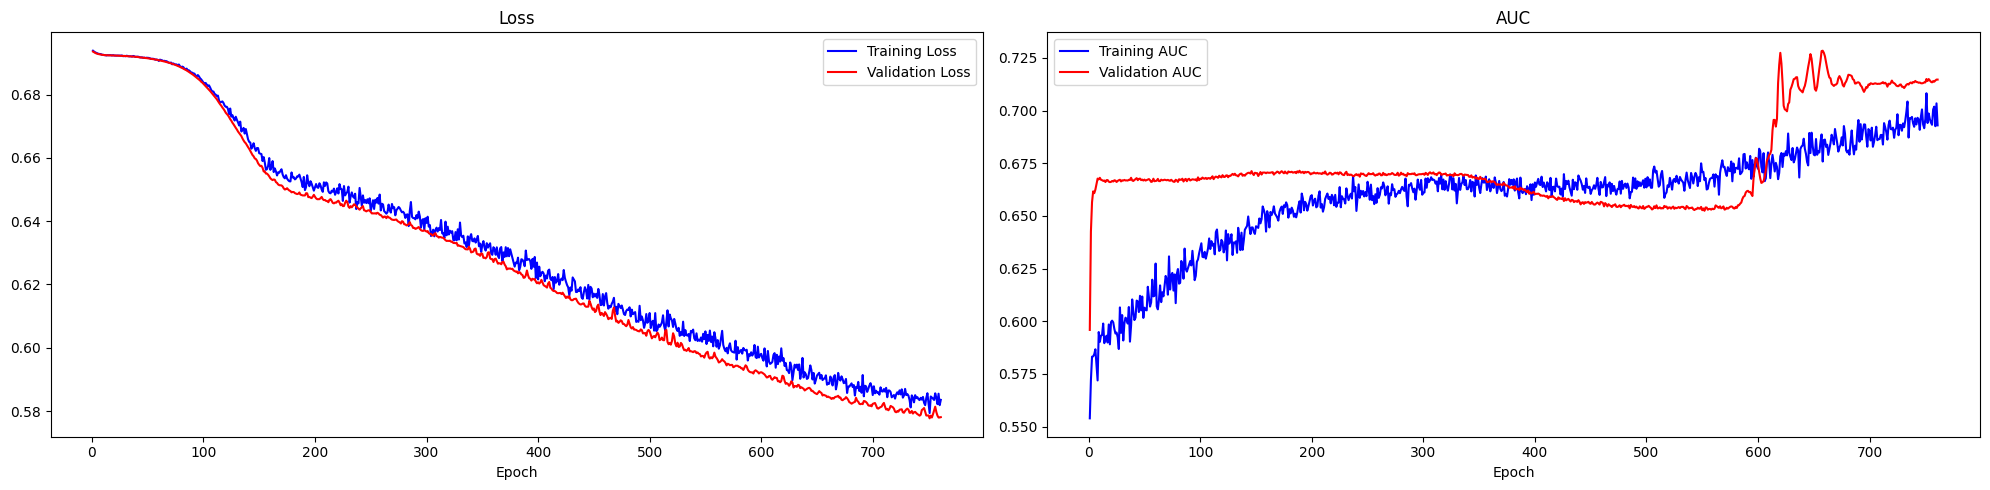


Best Metrics for Run 0:
Accuracy: 0.6627, F1: 0.7315, AUC: 0.7150
Epoch 1:
Train - Loss: 0.6931, Acc: 0.5000, F1: 0.0000, AUC: 0.5986
Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.6566
Epoch 2:
Train - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.6015
Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.6578
Epoch 3:
Train - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.6107
Val   - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6583
Epoch 4:
Train - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6071
Val   - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6589
Epoch 5:
Train - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6032
Val   - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6598
Epoch 6:
Train - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6025
Val   - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6603
Epoch 7:
Train - Loss: 0.6928, Acc: 0.5000, F1: 0.0000, AUC: 0.6146
Val   - Loss: 0.6929, Acc: 0.5000, F1: 0.0000, AUC: 0.6597
Epoch 8:
Train - Loss: 0.6928, Acc: 0.5000, 

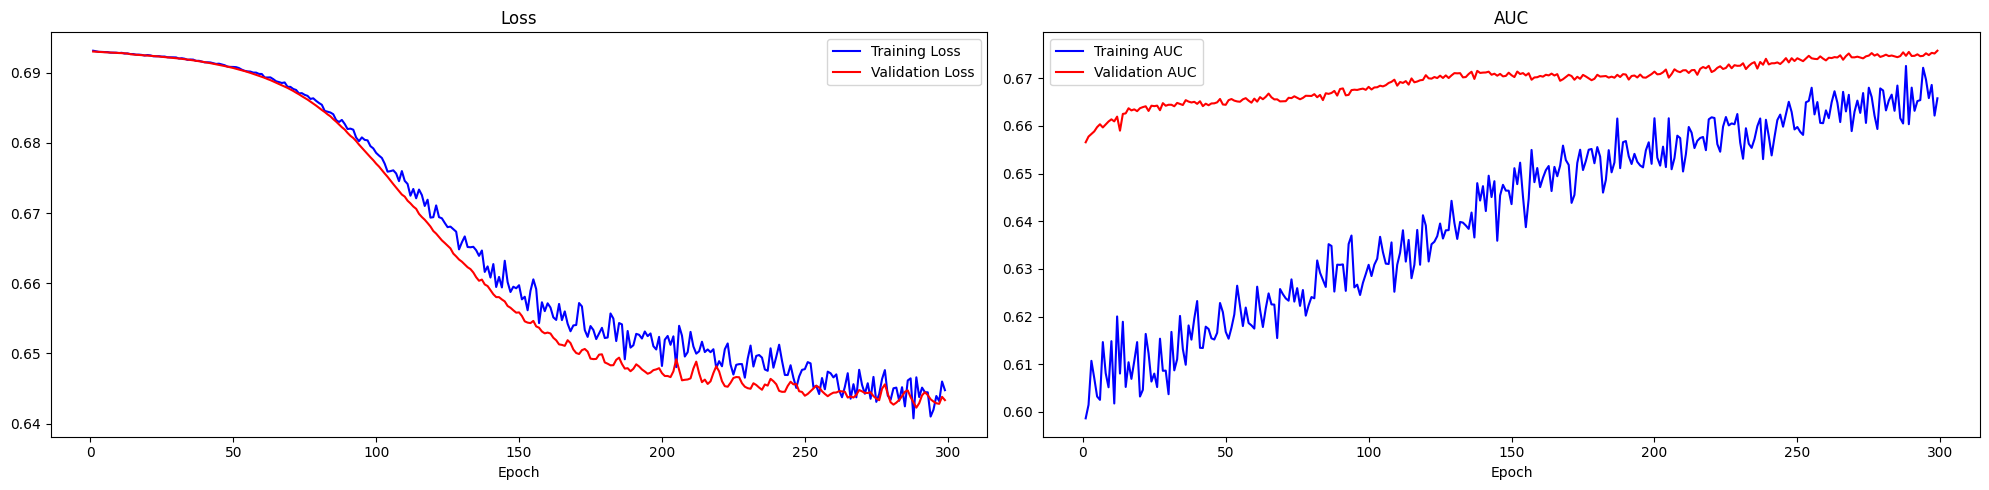


Best Metrics for Run 1:
Accuracy: 0.6163, F1: 0.6354, AUC: 0.6755
Epoch 1:
Train - Loss: 0.6941, Acc: 0.5000, F1: 0.6667, AUC: 0.4147
Val   - Loss: 0.6938, Acc: 0.5000, F1: 0.6667, AUC: 0.3834
Epoch 2:
Train - Loss: 0.6938, Acc: 0.5000, F1: 0.6667, AUC: 0.4285
Val   - Loss: 0.6936, Acc: 0.5000, F1: 0.6667, AUC: 0.4333
Epoch 3:
Train - Loss: 0.6936, Acc: 0.5000, F1: 0.6667, AUC: 0.4303
Val   - Loss: 0.6934, Acc: 0.5000, F1: 0.6667, AUC: 0.4374
Epoch 4:
Train - Loss: 0.6935, Acc: 0.5000, F1: 0.6667, AUC: 0.4471
Val   - Loss: 0.6933, Acc: 0.5000, F1: 0.6667, AUC: 0.4444
Epoch 5:
Train - Loss: 0.6933, Acc: 0.5002, F1: 0.6667, AUC: 0.4686
Val   - Loss: 0.6932, Acc: 0.4741, F1: 0.6244, AUC: 0.4735
Epoch 6:
Train - Loss: 0.6932, Acc: 0.5095, F1: 0.6456, AUC: 0.4877
Val   - Loss: 0.6931, Acc: 0.4999, F1: 0.0000, AUC: 0.5469
Epoch 7:
Train - Loss: 0.6931, Acc: 0.4814, F1: 0.0540, AUC: 0.5203
Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 0.5647
Epoch 8:
Train - Loss: 0.6930, Acc: 0.4992, 

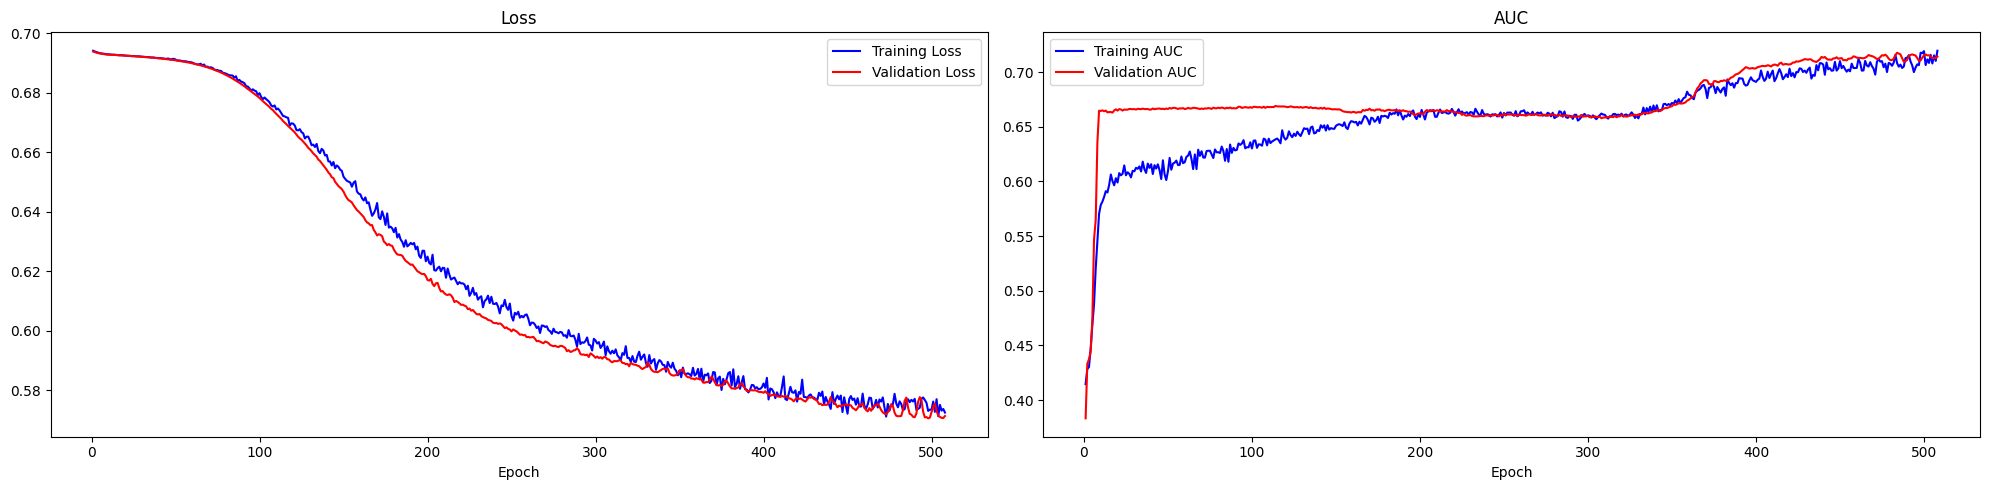


Best Metrics for Run 2:
Accuracy: 0.6654, F1: 0.7367, AUC: 0.7106


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for run in range(3):
  model = EdgePredictionModel(in_channels=1, hidden_channels=16, out_channels=1).to(device)

  dataset.x = dataset.x.to(device)
  dataset.edge_index = dataset.edge_index.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

  patience = 10
  best_val_loss = float('inf')
  patience_counter = 0

  train_metrics = {
      'loss': [], 'accuracy': [], 'f1': [], 'auc': []
  }
  val_metrics = {
      'loss': [], 'accuracy': [], 'f1': [], 'auc': []
  }

  num_epochs = 1000
  for epoch in range(num_epochs):
      train_loss, train_acc, train_f1, train_auc = train(model, dataset, optimizer, device)
      val_loss, val_acc, val_f1, val_auc = validate(model, dataset, device)

      train_metrics['loss'].append(train_loss)
      train_metrics['accuracy'].append(train_acc)
      train_metrics['f1'].append(train_f1)
      train_metrics['auc'].append(train_auc)

      val_metrics['loss'].append(val_loss)
      val_metrics['accuracy'].append(val_acc)
      val_metrics['f1'].append(val_f1)
      val_metrics['auc'].append(val_auc)

      print(f'Epoch {epoch + 1}:')
      print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
      print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_val_acc = val_acc
          best_val_f1 = val_f1
          best_val_auc = val_auc
          patience_counter = 0
          patience_counter = 0
      else:
          patience_counter += 1

      if patience_counter >= patience:
          print(f"Early stopping triggered at epoch {epoch + 1}")
          break

  print(f"\nBest Metrics for Run {run}:")
  print(f"Accuracy: {best_val_acc:.4f}, F1: {best_val_f1:.4f}, AUC: {best_val_auc:.4f}")